<a href="https://colab.research.google.com/github/DSGPproject/DSGP_model/blob/main/mat_not_working_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#this is importing the stuff

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

import tensorflow.keras as tfk
import tensorflow.keras.layers as tfl

import matplotlib.pyplot as plt

import numpy as np

%load_ext tensorboard

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
BATCH_SIZE = 32 #not sure
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=25 # iterations , passes made to find patterns/trends
#when the number of epochs are very high, the model memorises the images and does not find the patterns. so val accuracy is low

THIS IS IMPORTING THE DATASET FROM GOOGLE DRIVE

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory( #loading the dataset
     "/content/drive/MyDrive/dataset/only 75 in each",
    seed=123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)
class_names = dataset.class_names
class_names

Found 593 files belonging to 8 classes.


['Anthracnose',
 'algal leaf',
 'bird eye spot',
 'brown blight',
 'gray light',
 'healthy',
 'red leaf spot',
 'white spot']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 6 7 1 4 0 5 1 4 7 4 0 2 1 3 4 5 1 5 7 7 6 7 6 1 5 3 4 1 2 0 2]


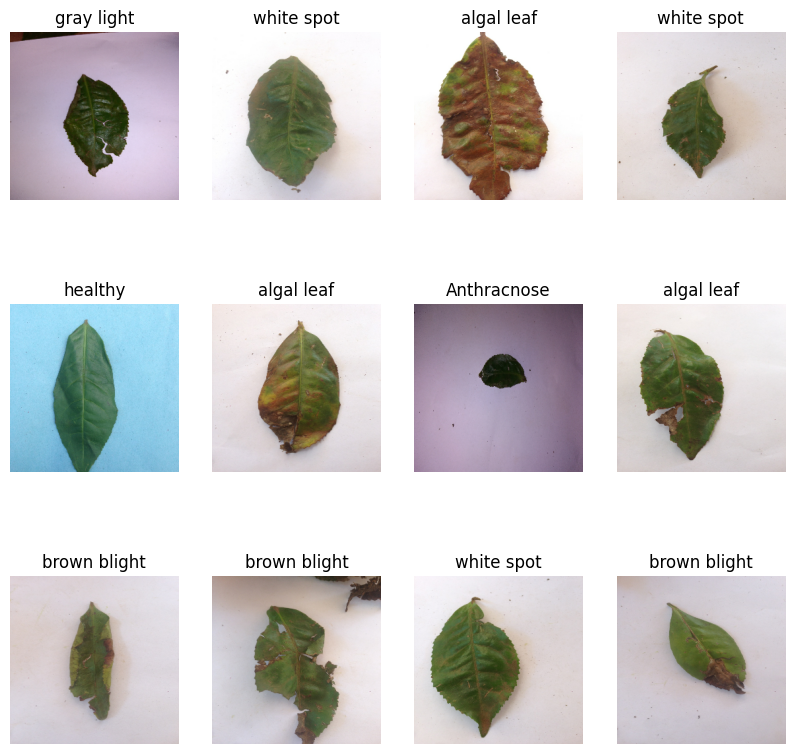

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

this is splitting the dataset into 3 , validation, testing , training

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds
#---------------------------------------------------

#getting the 3 things
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [8]:
#data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
])


In [9]:
#applying the augmentation to the train ds

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

THE MODEL

In [10]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model=tfk.Sequential([
    # 1
    tfl.Conv2D(32,3,padding='same'),
    tfl.BatchNormalization(),
    tfl.ReLU(),
    tfl.MaxPooling2D((2,2)),
    #2
    tfl.Conv2D(64,3,padding='same'),
    tfl.BatchNormalization(),
    tfl.ReLU(),
    tfl.MaxPooling2D((2,2)),
    #3
    tfl.Conv2D(128,3,padding='same'),
    tfl.BatchNormalization(),
    tfl.ReLU(),
    tfl.MaxPooling2D((2,2)),

    tfl.Flatten(),

    tfl.Dense(64,),
    tfl.BatchNormalization(),
    tfl.ReLU(),
    tfl.Dropout(rate= 0.2, seed= 123),

    tfl.Dense(128),
    tfl.BatchNormalization() ,
    tfl.ReLU(),
    tfl.Dropout(rate= 0.2, seed= 123),


    tfl.Dense(256),
    tfl.BatchNormalization() ,
    tfl.ReLU(),
    tfl.Dropout(rate= 0.2, seed= 123),


    tfl.Dense(8,activation='softmax')
])


In [11]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

model.compile(optimizer=tfk.optimizers.Adamax(learning_rate= lr_schedule),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
az

In [12]:
history = model.fit(train_ds,validation_data=val_ds, batch_size=32,epochs=25)

Epoch 1/25
15/15 [==============================] - 207s 10s/step - loss: 1.7675 - accuracy: 0.3604 - val_loss: 16.0497 - val_accuracy: 0.1250
Epoch 2/25
15/15 [==============================] - 117s 8s/step - loss: 1.3143 - accuracy: 0.4708 - val_loss: 5.6717 - val_accuracy: 0.1250
Epoch 3/25
15/15 [==============================] - 108s 7s/step - loss: 1.0891 - accuracy: 0.5458 - val_loss: 2.1362 - val_accuracy: 0.3750
Epoch 4/25
15/15 [==============================] - 109s 7s/step - loss: 0.9857 - accuracy: 0.6000 - val_loss: 1.9674 - val_accuracy: 0.2500
Epoch 5/25
15/15 [==============================] - 107s 7s/step - loss: 0.8816 - accuracy: 0.6250 - val_loss: 2.0027 - val_accuracy: 0.0938
Epoch 6/25
15/15 [==============================] - 107s 7s/step - loss: 0.8297 - accuracy: 0.6646 - val_loss: 1.8395 - val_accuracy: 0.1250
Epoch 7/25
15/15 [==============================] - 119s 8s/step - loss: 0.7731 - accuracy: 0.6750 - val_loss: 1.8271 - val_accuracy: 0.1875
Epoch 8/25


In [13]:
model.evaluate(val_ds)

1/1 [==============================] - 2s 2s/step - loss: 3.6478 - accuracy: 0.5000


[3.6478378772735596, 0.5]

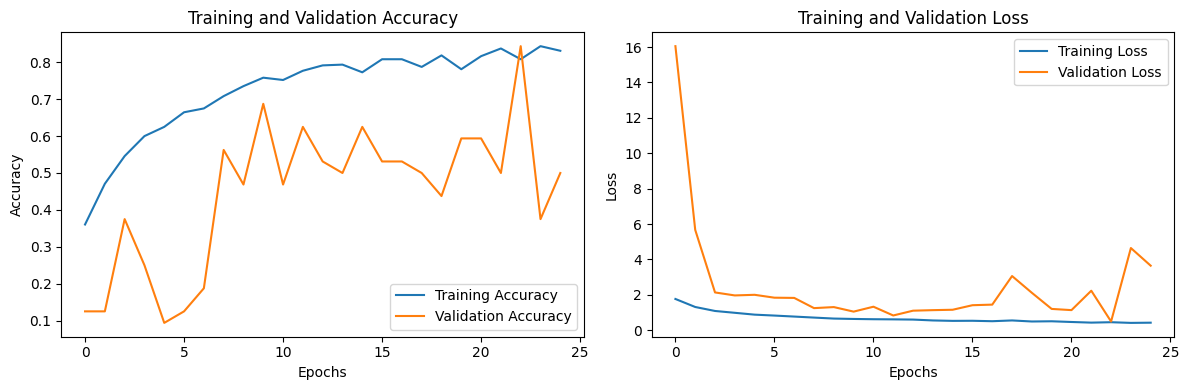

In [14]:
# Plotting the training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

first image to predict
actual label: brown blight
1/1 [==============================] - 2s 2s/step
predicted label: algal leaf


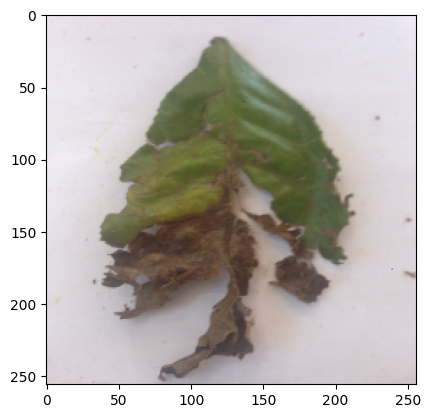

In [15]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [16]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 65ms/step


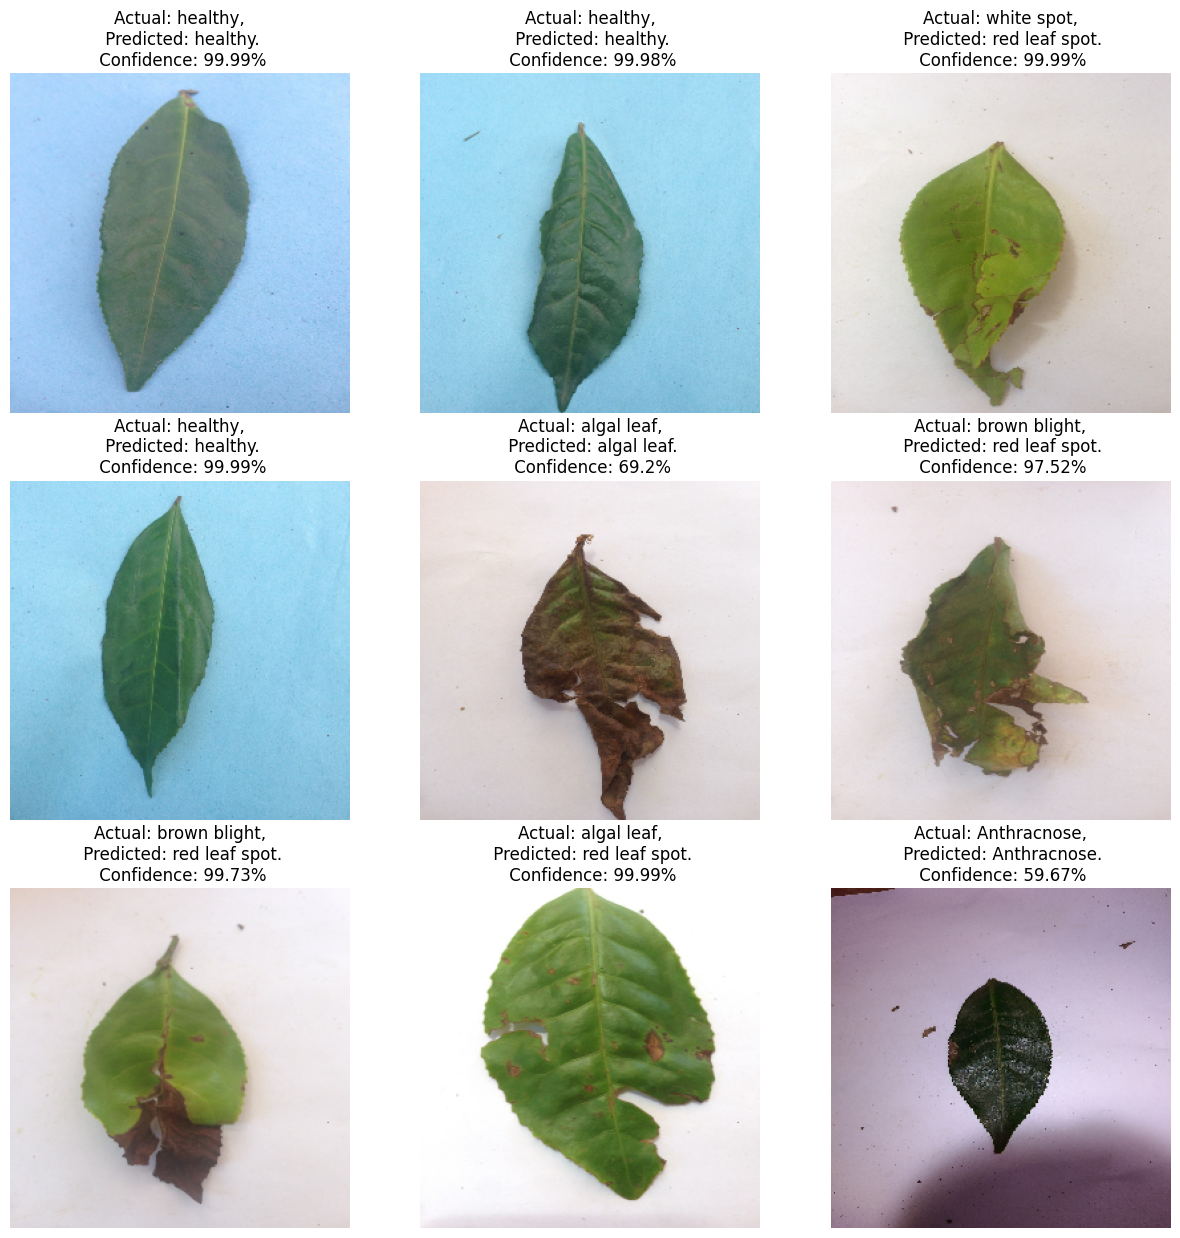

In [17]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 [==============================] - 0s 71ms/step


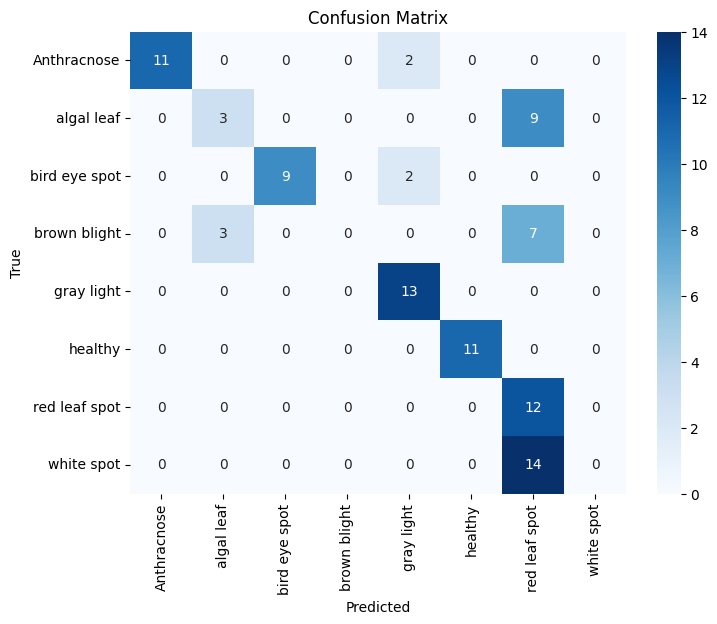

Classification Report:
                precision    recall  f1-score   support

  Anthracnose       1.00      0.85      0.92        13
   algal leaf       0.50      0.25      0.33        12
bird eye spot       1.00      0.82      0.90        11
 brown blight       0.00      0.00      0.00        10
   gray light       0.76      1.00      0.87        13
      healthy       1.00      1.00      1.00        11
red leaf spot       0.29      1.00      0.44        12
   white spot       0.00      0.00      0.00        14

     accuracy                           0.61        96
    macro avg       0.57      0.61      0.56        96
 weighted avg       0.57      0.61      0.56        96



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a test dataset, replace `test_ds` with your actual test dataset
# Get predictions from the model
predictions = []
true_labels = []

for images_batch, labels_batch in test_ds:
    for i in range(len(images_batch)):
        image = images_batch[i]
        label = labels_batch[i].numpy()

        # Reshape the image to (1, height, width, channels) for prediction
        image_for_prediction = tf.expand_dims(image, axis=0)

        # Make predictions
        predictions_batch = model.predict(image_for_prediction)
        predicted_label = np.argmax(predictions_batch[0])

        predictions.append(predicted_label)
        true_labels.append(label)

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(true_labels, predictions, target_names=class_names))

In [ ]:
import os
from keras.models import load_model

# Replace 'model' with the name of your model
model_name = '\3rd model from scratch_75ineach'

# Path to your Google Drive
drive_path = "/content/drive/MyDrive/colab_NoteBooks"

# Full path for saving the model
save_path = os.path.join(drive_path, model_name)

# Save the model
model.save(save_path)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
def random_hue(image, max_delta=0.2):
    return tf.image.adjust_hue(image, tf.random.uniform([], -max_delta, max_delta))

def random_brightness(image, max_delta=0.2):
    return tf.image.adjust_brightness(image, tf.random.uniform([], 1-max_delta, 1+max_delta))

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.Lambda(lambda x: random_hue(x)),
    layers.Lambda(lambda x: random_brightness(x)),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2)
])


In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,

    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

In [ ]:
model.compile(
    optimizer='adamax', #optimizer adamax
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #loss function
    metrics=['accuracy']  #accuracy
)

In [ ]:
history = model.fit( #traning the model
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1, #have to check
    epochs=50,
)

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
type(history.history['loss'])

In [ ]:

len(history.history['loss'])

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import os
from keras.models import load_model

# Replace 'model' with the name of your model
model_name = 'final1'

# Path to your Google Drive
drive_path = "/content/drive/MyDrive/colab_NoteBooks"

# Full path for saving the model
save_path = os.path.join(drive_path, model_name)

# Save the model
model.save(save_path)